## Gesture Recognition Training for Summit AI Demo

* Read training data from S3
* Combine multiple json files into single time-series.
* Featurize time-series data
* Train and test Random Forest model
* Train and test Feed-Forward model
* Save model for use by TF-Serve

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
from natsort import natsorted
import json
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

In [3]:
def collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = [df, label, np.arange(0,100,10)]
        example = featurize(params)
        data.append(example)
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


def mp_collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    data_params = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = (df, label, np.arange(0,100,10))
        data_params.append(params)
        
    #then = time.time()
    pool = mp.Pool(processes=8)
    data = pool.map(featurize,data_params)
    #print((time.time()-then)/60, "minutes")
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


In [4]:
def combine_multiple_json(bottom_dir):
    
    df = pd.DataFrame([])
    obj = []
    
    for partial_json  in bottom_dir:
        x = fs.open(partial_json)
        data = x.read()
        x.close()
        temp = json.loads(data)
        obj.append(temp['motion'])
        
    return obj # list of motion data in multiple json files representing one capture session

def turn_jsons_into_joint_dataframe(a_list):
    df = pd.DataFrame()
    for item in a_list:
        temp = pd.io.json.json_normalize(item)
        df = df.append(temp, ignore_index=True, sort=False)
        df = df.iloc[:,0:3]
  
    return df # 3xn dataframe of acceleration data  

def get_accleration_timeseries(timeseries):
    
    timeseries = timeseries.apply((lambda x: x**2))
    timeseries = timeseries.sum(axis=1)
    timeseries = timeseries.apply(np.sqrt)
    
    return timeseries # 1xn Series 

def featurize(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    
    return features
    

### Get Data

Pull gesture data from S3 and convert it into a featurized representation. 

In [5]:
then = time.time()

path_to_data = '/O'
fs = s3fs.S3FileSystem()
gesture_O = mp_collect_featured_data_from_s3(path_to_data,fs, 'O')
  
print((time.time()-then)/60, "minutes")

/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


1.0114180286725363 minutes


In [6]:
then = time.time()

path_to_data = '/X'
fs = s3fs.S3FileSystem()
gesture_X = mp_collect_featured_data_from_s3(path_to_data,fs, 'X')
  
print((time.time()-then)/60, "minutes")

1.0047680298487345 minutes


In [7]:
Data = gesture_O[:185] + gesture_X

In [8]:
df = pd.DataFrame(Data)

### Model Training

Split the data for training and testing with both a Random Forest model and a Feed-Forward network. 

In [9]:
df = df.dropna()

In [10]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (276, 14)
test size = (93, 14)
X    140
O    136
Name: label, dtype: int64
O    48
X    45
Name: label, dtype: int64


/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
train_df = train_df.dropna()
test_df = test_df.dropna()

#### Random Forest (sklearn)

In [12]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.9637681159420289, test_acc = 0.8494623655913979


Text(0, 0.5, 'predicted')

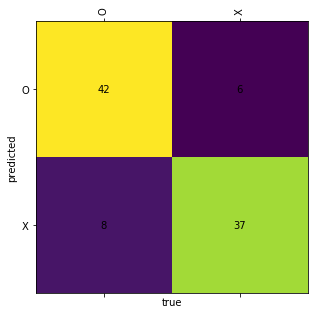

In [13]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

#### Feed-Forward (TF)

In [14]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)

one_hot = np.array(test_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.fit_transform(integer_encoder)

In [15]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(13,)),
    keras.layers.Dense(2, activation=tf.nn.log_softmax)
]) 

In [16]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

In [17]:
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

In [18]:
history = model.fit( train_df.drop('label', axis=1), train_label, epochs=5000, batch_size=100, verbose=1)

Epoch 1/5000
276/276 [==============================] - 0s 394us/step - loss: 11.9134 - acc: 0.4928
Epoch 2/5000
276/276 [==============================] - 0s 13us/step - loss: 11.1153 - acc: 0.4928
Epoch 3/5000
276/276 [==============================] - 0s 9us/step - loss: 10.3028 - acc: 0.4928
Epoch 4/5000
276/276 [==============================] - 0s 18us/step - loss: 9.4286 - acc: 0.4928
Epoch 5/5000
276/276 [==============================] - 0s 18us/step - loss: 8.6414 - acc: 0.4928
Epoch 6/5000
276/276 [==============================] - 0s 18us/step - loss: 7.8712 - acc: 0.4928
Epoch 7/5000
276/276 [==============================] - 0s 13us/step - loss: 7.0296 - acc: 0.4928
Epoch 8/5000
276/276 [==============================] - 0s 17us/step - loss: 6.2185 - acc: 0.4928
Epoch 9/5000
276/276 [==============================] - 0s 20us/step - loss: 5.4470 - acc: 0.4928
Epoch 10/5000
276/276 [==============================] - 0s 20us/step - loss: 4.5921 - acc: 0.4928
Epoch 11/5000
27

276/276 [==============================] - 0s 12us/step - loss: 0.7335 - acc: 0.4275
Epoch 84/5000
276/276 [==============================] - 0s 21us/step - loss: 0.7318 - acc: 0.4312
Epoch 85/5000
276/276 [==============================] - 0s 17us/step - loss: 0.7304 - acc: 0.4384
Epoch 86/5000
276/276 [==============================] - 0s 15us/step - loss: 0.7285 - acc: 0.4384
Epoch 87/5000
276/276 [==============================] - 0s 18us/step - loss: 0.7268 - acc: 0.4420
Epoch 88/5000
276/276 [==============================] - 0s 13us/step - loss: 0.7252 - acc: 0.4420
Epoch 89/5000
276/276 [==============================] - 0s 15us/step - loss: 0.7230 - acc: 0.4601
Epoch 90/5000
276/276 [==============================] - 0s 29us/step - loss: 0.7219 - acc: 0.4638
Epoch 91/5000
276/276 [==============================] - 0s 13us/step - loss: 0.7202 - acc: 0.4638
Epoch 92/5000
276/276 [==============================] - 0s 13us/step - loss: 0.7187 - acc: 0.4710
Epoch 93/5000
276/276 [=

276/276 [==============================] - 0s 13us/step - loss: 0.6214 - acc: 0.7971
Epoch 166/5000
276/276 [==============================] - 0s 16us/step - loss: 0.6207 - acc: 0.7862
Epoch 167/5000
276/276 [==============================] - 0s 17us/step - loss: 0.6195 - acc: 0.8007
Epoch 168/5000
276/276 [==============================] - 0s 16us/step - loss: 0.6185 - acc: 0.8188
Epoch 169/5000
276/276 [==============================] - 0s 20us/step - loss: 0.6178 - acc: 0.8370
Epoch 170/5000
276/276 [==============================] - 0s 14us/step - loss: 0.6167 - acc: 0.8478
Epoch 171/5000
276/276 [==============================] - 0s 12us/step - loss: 0.6154 - acc: 0.8333
Epoch 172/5000
276/276 [==============================] - 0s 19us/step - loss: 0.6143 - acc: 0.8333
Epoch 173/5000
276/276 [==============================] - 0s 19us/step - loss: 0.6136 - acc: 0.8297
Epoch 174/5000
276/276 [==============================] - 0s 14us/step - loss: 0.6131 - acc: 0.8297
Epoch 175/5000


276/276 [==============================] - 0s 26us/step - loss: 0.5549 - acc: 0.8587
Epoch 248/5000
276/276 [==============================] - 0s 16us/step - loss: 0.5536 - acc: 0.8623
Epoch 249/5000
276/276 [==============================] - 0s 11us/step - loss: 0.5534 - acc: 0.8551
Epoch 250/5000
276/276 [==============================] - 0s 27us/step - loss: 0.5526 - acc: 0.8659
Epoch 251/5000
276/276 [==============================] - 0s 13us/step - loss: 0.5521 - acc: 0.8732
Epoch 252/5000
276/276 [==============================] - 0s 14us/step - loss: 0.5523 - acc: 0.8514
Epoch 253/5000
276/276 [==============================] - 0s 18us/step - loss: 0.5512 - acc: 0.8478
Epoch 254/5000
276/276 [==============================] - 0s 15us/step - loss: 0.5500 - acc: 0.8478
Epoch 255/5000
276/276 [==============================] - 0s 16us/step - loss: 0.5493 - acc: 0.8623
Epoch 256/5000
276/276 [==============================] - 0s 29us/step - loss: 0.5497 - acc: 0.8804
Epoch 257/5000


276/276 [==============================] - 0s 17us/step - loss: 0.5133 - acc: 0.8551
Epoch 330/5000
276/276 [==============================] - 0s 12us/step - loss: 0.5124 - acc: 0.8406
Epoch 331/5000
276/276 [==============================] - 0s 18us/step - loss: 0.5122 - acc: 0.8333
Epoch 332/5000
276/276 [==============================] - 0s 16us/step - loss: 0.5120 - acc: 0.8297
Epoch 333/5000
276/276 [==============================] - 0s 16us/step - loss: 0.5121 - acc: 0.8478
Epoch 334/5000
276/276 [==============================] - 0s 22us/step - loss: 0.5103 - acc: 0.8623
Epoch 335/5000
276/276 [==============================] - 0s 18us/step - loss: 0.5124 - acc: 0.8659
Epoch 336/5000
276/276 [==============================] - 0s 17us/step - loss: 0.5096 - acc: 0.8623
Epoch 337/5000
276/276 [==============================] - 0s 17us/step - loss: 0.5117 - acc: 0.8514
Epoch 338/5000
276/276 [==============================] - 0s 21us/step - loss: 0.5095 - acc: 0.8333
Epoch 339/5000


276/276 [==============================] - 0s 18us/step - loss: 0.4881 - acc: 0.8623
Epoch 412/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4873 - acc: 0.8623
Epoch 413/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4855 - acc: 0.8442
Epoch 414/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4848 - acc: 0.8406
Epoch 415/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4849 - acc: 0.8370
Epoch 416/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4844 - acc: 0.8333
Epoch 417/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4841 - acc: 0.8478
Epoch 418/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4835 - acc: 0.8478
Epoch 419/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4833 - acc: 0.8406
Epoch 420/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4833 - acc: 0.8370
Epoch 421/5000


276/276 [==============================] - 0s 13us/step - loss: 0.4675 - acc: 0.8514
Epoch 494/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4683 - acc: 0.8514
Epoch 495/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4694 - acc: 0.8478
Epoch 496/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4662 - acc: 0.8442
Epoch 497/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4662 - acc: 0.8478
Epoch 498/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4656 - acc: 0.8442
Epoch 499/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4657 - acc: 0.8514
Epoch 500/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4665 - acc: 0.8551
Epoch 501/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4662 - acc: 0.8514
Epoch 502/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4655 - acc: 0.8514
Epoch 503/5000


276/276 [==============================] - 0s 26us/step - loss: 0.4588 - acc: 0.8478
Epoch 576/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4558 - acc: 0.8370
Epoch 577/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4547 - acc: 0.8442
Epoch 578/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4549 - acc: 0.8551
Epoch 579/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4541 - acc: 0.8587
Epoch 580/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4542 - acc: 0.8587
Epoch 581/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4539 - acc: 0.8370
Epoch 582/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4537 - acc: 0.8370
Epoch 583/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4536 - acc: 0.8442
Epoch 584/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4551 - acc: 0.8587
Epoch 585/5000


276/276 [==============================] - 0s 11us/step - loss: 0.4447 - acc: 0.8514
Epoch 658/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4455 - acc: 0.8587
Epoch 659/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4463 - acc: 0.8587
Epoch 660/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4448 - acc: 0.8442
Epoch 661/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4449 - acc: 0.8514
Epoch 662/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4455 - acc: 0.8478
Epoch 663/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4448 - acc: 0.8478
Epoch 664/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4453 - acc: 0.8478
Epoch 665/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4441 - acc: 0.8514
Epoch 666/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4451 - acc: 0.8442
Epoch 667/5000


276/276 [==============================] - 0s 18us/step - loss: 0.4409 - acc: 0.8442
Epoch 740/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4377 - acc: 0.8514
Epoch 741/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4371 - acc: 0.8478
Epoch 742/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4380 - acc: 0.8442
Epoch 743/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4402 - acc: 0.8333
Epoch 744/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4384 - acc: 0.8370
Epoch 745/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4377 - acc: 0.8297
Epoch 746/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4375 - acc: 0.8478
Epoch 747/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4370 - acc: 0.8442
Epoch 748/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4396 - acc: 0.8406
Epoch 749/5000


276/276 [==============================] - 0s 26us/step - loss: 0.4330 - acc: 0.8406
Epoch 821/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4345 - acc: 0.8297
Epoch 822/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4333 - acc: 0.8370
Epoch 823/5000
276/276 [==============================] - 0s 28us/step - loss: 0.4335 - acc: 0.8333
Epoch 824/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4383 - acc: 0.8478
Epoch 825/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4340 - acc: 0.8406
Epoch 826/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4333 - acc: 0.8406
Epoch 827/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4330 - acc: 0.8370
Epoch 828/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4337 - acc: 0.8370
Epoch 829/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4321 - acc: 0.8406
Epoch 830/5000


276/276 [==============================] - 0s 15us/step - loss: 0.4293 - acc: 0.8333
Epoch 903/5000
276/276 [==============================] - 0s 29us/step - loss: 0.4329 - acc: 0.8406
Epoch 904/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4290 - acc: 0.8478
Epoch 905/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4302 - acc: 0.8406
Epoch 906/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4286 - acc: 0.8333
Epoch 907/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4281 - acc: 0.8370
Epoch 908/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4285 - acc: 0.8370
Epoch 909/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4358 - acc: 0.8406
Epoch 910/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4330 - acc: 0.8478
Epoch 911/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4288 - acc: 0.8333
Epoch 912/5000


276/276 [==============================] - 0s 13us/step - loss: 0.4262 - acc: 0.8478
Epoch 985/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4267 - acc: 0.8442
Epoch 986/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4291 - acc: 0.8442
Epoch 987/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4288 - acc: 0.8442
Epoch 988/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4278 - acc: 0.8333
Epoch 989/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4259 - acc: 0.8333
Epoch 990/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4253 - acc: 0.8370
Epoch 991/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4281 - acc: 0.8442
Epoch 992/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4266 - acc: 0.8442
Epoch 993/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4246 - acc: 0.8406
Epoch 994/5000


276/276 [==============================] - 0s 16us/step - loss: 0.4260 - acc: 0.8333
Epoch 1066/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4248 - acc: 0.8333
Epoch 1067/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4241 - acc: 0.8297
Epoch 1068/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4246 - acc: 0.8406
Epoch 1069/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4234 - acc: 0.8442
Epoch 1070/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4242 - acc: 0.8478
Epoch 1071/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4239 - acc: 0.8442
Epoch 1072/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4236 - acc: 0.8478
Epoch 1073/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4243 - acc: 0.8406
Epoch 1074/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4242 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 25us/step - loss: 0.4241 - acc: 0.8442
Epoch 1147/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4219 - acc: 0.8478
Epoch 1148/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4218 - acc: 0.8406
Epoch 1149/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4246 - acc: 0.8297
Epoch 1150/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4224 - acc: 0.8333
Epoch 1151/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4211 - acc: 0.8370
Epoch 1152/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4229 - acc: 0.8442
Epoch 1153/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4246 - acc: 0.8442
Epoch 1154/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4221 - acc: 0.8442
Epoch 1155/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4247 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 22us/step - loss: 0.4237 - acc: 0.8442
Epoch 1228/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4207 - acc: 0.8478
Epoch 1229/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4206 - acc: 0.8478
Epoch 1230/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4224 - acc: 0.8406
Epoch 1231/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4208 - acc: 0.8333
Epoch 1232/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4200 - acc: 0.8406
Epoch 1233/5000
276/276 [==============================] - 0s 28us/step - loss: 0.4213 - acc: 0.8442
Epoch 1234/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4235 - acc: 0.8442
Epoch 1235/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4224 - acc: 0.8442
Epoch 1236/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4192 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 13us/step - loss: 0.4246 - acc: 0.8406
Epoch 1309/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4199 - acc: 0.8478
Epoch 1310/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4199 - acc: 0.8478
Epoch 1311/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4214 - acc: 0.8478
Epoch 1312/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4198 - acc: 0.8442
Epoch 1313/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4218 - acc: 0.8333
Epoch 1314/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4223 - acc: 0.8370
Epoch 1315/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4196 - acc: 0.8478
Epoch 1316/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4194 - acc: 0.8478
Epoch 1317/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4214 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4218 - acc: 0.8406
Epoch 1390/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4237 - acc: 0.8370
Epoch 1391/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4202 - acc: 0.8442
Epoch 1392/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4231 - acc: 0.8333
Epoch 1393/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4203 - acc: 0.8370
Epoch 1394/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4242 - acc: 0.8333
Epoch 1395/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4222 - acc: 0.8406
Epoch 1396/5000
276/276 [==============================] - 0s 27us/step - loss: 0.4195 - acc: 0.8442
Epoch 1397/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4191 - acc: 0.8370
Epoch 1398/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4207 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 18us/step - loss: 0.4207 - acc: 0.8333
Epoch 1471/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4247 - acc: 0.8478
Epoch 1472/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4193 - acc: 0.8442
Epoch 1473/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4193 - acc: 0.8478
Epoch 1474/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4208 - acc: 0.8406
Epoch 1475/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4185 - acc: 0.8370
Epoch 1476/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4225 - acc: 0.8478
Epoch 1477/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4182 - acc: 0.8442
Epoch 1478/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4189 - acc: 0.8442
Epoch 1479/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4196 - acc: 0.8370
Epoch 

276/276 [==============================] - 0s 12us/step - loss: 0.4196 - acc: 0.8370
Epoch 1552/5000
276/276 [==============================] - 0s 28us/step - loss: 0.4222 - acc: 0.8406
Epoch 1553/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4190 - acc: 0.8478
Epoch 1554/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4182 - acc: 0.8478
Epoch 1555/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4222 - acc: 0.8478
Epoch 1556/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4205 - acc: 0.8370
Epoch 1557/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4177 - acc: 0.8370
Epoch 1558/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4186 - acc: 0.8442
Epoch 1559/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4196 - acc: 0.8406
Epoch 1560/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4195 - acc: 0.8370
Epoch 

276/276 [==============================] - 0s 17us/step - loss: 0.4192 - acc: 0.8333
Epoch 1633/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4209 - acc: 0.8333
Epoch 1634/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4188 - acc: 0.8333
Epoch 1635/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4172 - acc: 0.8442
Epoch 1636/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4221 - acc: 0.8442
Epoch 1637/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4219 - acc: 0.8406
Epoch 1638/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4187 - acc: 0.8478
Epoch 1639/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4171 - acc: 0.8442
Epoch 1640/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4177 - acc: 0.8442
Epoch 1641/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4182 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 18us/step - loss: 0.4215 - acc: 0.8406
Epoch 1714/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4235 - acc: 0.8333
Epoch 1715/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4208 - acc: 0.8333
Epoch 1716/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4213 - acc: 0.8333
Epoch 1717/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4173 - acc: 0.8478
Epoch 1718/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4214 - acc: 0.8406
Epoch 1719/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4228 - acc: 0.8370
Epoch 1720/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4193 - acc: 0.8333
Epoch 1721/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4184 - acc: 0.8333
Epoch 1722/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4163 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4179 - acc: 0.8333
Epoch 1795/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4176 - acc: 0.8442
Epoch 1796/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4179 - acc: 0.8370
Epoch 1797/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4170 - acc: 0.8442
Epoch 1798/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4172 - acc: 0.8406
Epoch 1799/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4177 - acc: 0.8442
Epoch 1800/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4179 - acc: 0.8442
Epoch 1801/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4227 - acc: 0.8333
Epoch 1802/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4213 - acc: 0.8370
Epoch 1803/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4170 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 14us/step - loss: 0.4185 - acc: 0.8406
Epoch 1876/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4178 - acc: 0.8406
Epoch 1877/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4183 - acc: 0.8478
Epoch 1878/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4181 - acc: 0.8406
Epoch 1879/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4192 - acc: 0.8406
Epoch 1880/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4173 - acc: 0.8442
Epoch 1881/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4177 - acc: 0.8406
Epoch 1882/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4181 - acc: 0.8406
Epoch 1883/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4198 - acc: 0.8406
Epoch 1884/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4191 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 12us/step - loss: 0.4193 - acc: 0.8333
Epoch 1957/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4183 - acc: 0.8370
Epoch 1958/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4156 - acc: 0.8442
Epoch 1959/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4167 - acc: 0.8406
Epoch 1960/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4171 - acc: 0.8370
Epoch 1961/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4175 - acc: 0.8370
Epoch 1962/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4179 - acc: 0.8370
Epoch 1963/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4208 - acc: 0.8406
Epoch 1964/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4189 - acc: 0.8442
Epoch 1965/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4176 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 14us/step - loss: 0.4183 - acc: 0.8406
Epoch 2038/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4169 - acc: 0.8370
Epoch 2039/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4160 - acc: 0.8442
Epoch 2040/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4173 - acc: 0.8406
Epoch 2041/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4191 - acc: 0.8333
Epoch 2042/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4161 - acc: 0.8370
Epoch 2043/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4182 - acc: 0.8406
Epoch 2044/5000
276/276 [==============================] - 0s 27us/step - loss: 0.4181 - acc: 0.8370
Epoch 2045/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4197 - acc: 0.8370
Epoch 2046/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4156 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 22us/step - loss: 0.4168 - acc: 0.8442
Epoch 2119/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4190 - acc: 0.8442
Epoch 2120/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4167 - acc: 0.8370
Epoch 2121/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4195 - acc: 0.8442
Epoch 2122/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4214 - acc: 0.8514
Epoch 2123/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4167 - acc: 0.8370
Epoch 2124/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4183 - acc: 0.8442
Epoch 2125/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4162 - acc: 0.8442
Epoch 2126/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4174 - acc: 0.8442
Epoch 2127/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4167 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 14us/step - loss: 0.4173 - acc: 0.8442
Epoch 2200/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4182 - acc: 0.8442
Epoch 2201/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4162 - acc: 0.8442
Epoch 2202/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4167 - acc: 0.8442
Epoch 2203/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4182 - acc: 0.8406
Epoch 2204/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4187 - acc: 0.8478
Epoch 2205/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4164 - acc: 0.8442
Epoch 2206/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4195 - acc: 0.8406
Epoch 2207/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4189 - acc: 0.8406
Epoch 2208/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4173 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4165 - acc: 0.8406
Epoch 2281/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4164 - acc: 0.8406
Epoch 2282/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4167 - acc: 0.8406
Epoch 2283/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4174 - acc: 0.8370
Epoch 2284/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4187 - acc: 0.8406
Epoch 2285/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4194 - acc: 0.8406
Epoch 2286/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4182 - acc: 0.8406
Epoch 2287/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4162 - acc: 0.8442
Epoch 2288/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4156 - acc: 0.8442
Epoch 2289/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4185 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 15us/step - loss: 0.4164 - acc: 0.8406
Epoch 2362/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4192 - acc: 0.8370
Epoch 2363/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4191 - acc: 0.8406
Epoch 2364/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4160 - acc: 0.8442
Epoch 2365/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4167 - acc: 0.8406
Epoch 2366/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4191 - acc: 0.8442
Epoch 2367/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4163 - acc: 0.8442
Epoch 2368/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4175 - acc: 0.8442
Epoch 2369/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4163 - acc: 0.8442
Epoch 2370/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4165 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 15us/step - loss: 0.4165 - acc: 0.8406
Epoch 2443/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4189 - acc: 0.8406
Epoch 2444/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4167 - acc: 0.8406
Epoch 2445/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4162 - acc: 0.8370
Epoch 2446/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4219 - acc: 0.8370
Epoch 2447/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4169 - acc: 0.8406
Epoch 2448/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4156 - acc: 0.8442
Epoch 2449/5000
276/276 [==============================] - 0s 32us/step - loss: 0.4170 - acc: 0.8406
Epoch 2450/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4176 - acc: 0.8442
Epoch 2451/5000
276/276 [==============================] - 0s 27us/step - loss: 0.4183 - acc: 0.8370
Epoch 

276/276 [==============================] - 0s 15us/step - loss: 0.4142 - acc: 0.8406
Epoch 2524/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4161 - acc: 0.8370
Epoch 2525/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4204 - acc: 0.8370
Epoch 2526/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4181 - acc: 0.8370
Epoch 2527/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4168 - acc: 0.8442
Epoch 2528/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4162 - acc: 0.8442
Epoch 2529/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4176 - acc: 0.8406
Epoch 2530/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4152 - acc: 0.8442
Epoch 2531/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4147 - acc: 0.8442
Epoch 2532/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4165 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 17us/step - loss: 0.4191 - acc: 0.8442
Epoch 2605/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4164 - acc: 0.8406
Epoch 2606/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4163 - acc: 0.8406
Epoch 2607/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4166 - acc: 0.8478
Epoch 2608/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4164 - acc: 0.8406
Epoch 2609/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4157 - acc: 0.8442
Epoch 2610/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4163 - acc: 0.8442
Epoch 2611/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4158 - acc: 0.8442
Epoch 2612/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4177 - acc: 0.8406
Epoch 2613/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4169 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 20us/step - loss: 0.4157 - acc: 0.8406
Epoch 2686/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4174 - acc: 0.8406
Epoch 2687/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4177 - acc: 0.8406
Epoch 2688/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4165 - acc: 0.8406
Epoch 2689/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4148 - acc: 0.8370
Epoch 2690/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4165 - acc: 0.8478
Epoch 2691/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4180 - acc: 0.8442
Epoch 2692/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4231 - acc: 0.8406
Epoch 2693/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4208 - acc: 0.8333
Epoch 2694/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4153 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 22us/step - loss: 0.4150 - acc: 0.8442
Epoch 2767/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4149 - acc: 0.8442
Epoch 2768/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4164 - acc: 0.8478
Epoch 2769/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4161 - acc: 0.8478
Epoch 2770/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4155 - acc: 0.8442
Epoch 2771/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4190 - acc: 0.8370
Epoch 2772/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4161 - acc: 0.8406
Epoch 2773/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4199 - acc: 0.8333
Epoch 2774/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4176 - acc: 0.8370
Epoch 2775/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4157 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 12us/step - loss: 0.4150 - acc: 0.8406
Epoch 2848/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4160 - acc: 0.8478
Epoch 2849/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4155 - acc: 0.8406
Epoch 2850/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4167 - acc: 0.8406
Epoch 2851/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4190 - acc: 0.8370
Epoch 2852/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4174 - acc: 0.8478
Epoch 2853/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4167 - acc: 0.8406
Epoch 2854/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4178 - acc: 0.8406
Epoch 2855/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4165 - acc: 0.8406
Epoch 2856/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4163 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 17us/step - loss: 0.4157 - acc: 0.8478
Epoch 2928/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4150 - acc: 0.8442
Epoch 2929/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4156 - acc: 0.8442
Epoch 2930/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4161 - acc: 0.8442
Epoch 2931/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4196 - acc: 0.8442
Epoch 2932/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4156 - acc: 0.8478
Epoch 2933/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4154 - acc: 0.8442
Epoch 2934/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4152 - acc: 0.8442
Epoch 2935/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4160 - acc: 0.8478
Epoch 2936/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4159 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 24us/step - loss: 0.4164 - acc: 0.8370
Epoch 3009/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4167 - acc: 0.8406
Epoch 3010/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4170 - acc: 0.8514
Epoch 3011/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4184 - acc: 0.8514
Epoch 3012/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4182 - acc: 0.8406
Epoch 3013/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4169 - acc: 0.8442
Epoch 3014/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4148 - acc: 0.8478
Epoch 3015/5000
276/276 [==============================] - 0s 27us/step - loss: 0.4158 - acc: 0.8370
Epoch 3016/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4170 - acc: 0.8370
Epoch 3017/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4156 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4174 - acc: 0.8406
Epoch 3090/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4179 - acc: 0.8442
Epoch 3091/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4161 - acc: 0.8478
Epoch 3092/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4168 - acc: 0.8442
Epoch 3093/5000
276/276 [==============================] - 0s 29us/step - loss: 0.4155 - acc: 0.8406
Epoch 3094/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4181 - acc: 0.8370
Epoch 3095/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4146 - acc: 0.8370
Epoch 3096/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4139 - acc: 0.8478
Epoch 3097/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4171 - acc: 0.8406
Epoch 3098/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4212 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 25us/step - loss: 0.4165 - acc: 0.8406
Epoch 3171/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4130 - acc: 0.8406
Epoch 3172/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4155 - acc: 0.8478
Epoch 3173/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4181 - acc: 0.8261
Epoch 3174/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4189 - acc: 0.8333
Epoch 3175/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4197 - acc: 0.8514
Epoch 3176/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4154 - acc: 0.8406
Epoch 3177/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4164 - acc: 0.8406
Epoch 3178/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4172 - acc: 0.8406
Epoch 3179/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4196 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 26us/step - loss: 0.4169 - acc: 0.8478
Epoch 3252/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4159 - acc: 0.8478
Epoch 3253/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4151 - acc: 0.8478
Epoch 3254/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4144 - acc: 0.8442
Epoch 3255/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4154 - acc: 0.8370
Epoch 3256/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4165 - acc: 0.8406
Epoch 3257/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4154 - acc: 0.8406
Epoch 3258/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4151 - acc: 0.8442
Epoch 3259/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4147 - acc: 0.8406
Epoch 3260/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4147 - acc: 0.8514
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4153 - acc: 0.8406
Epoch 3333/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4168 - acc: 0.8406
Epoch 3334/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4137 - acc: 0.8370
Epoch 3335/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4193 - acc: 0.8370
Epoch 3336/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4194 - acc: 0.8297
Epoch 3337/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4157 - acc: 0.8514
Epoch 3338/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4145 - acc: 0.8514
Epoch 3339/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4147 - acc: 0.8406
Epoch 3340/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4166 - acc: 0.8406
Epoch 3341/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4167 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 14us/step - loss: 0.4166 - acc: 0.8442
Epoch 3414/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4164 - acc: 0.8478
Epoch 3415/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4153 - acc: 0.8514
Epoch 3416/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4171 - acc: 0.8478
Epoch 3417/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4148 - acc: 0.8478
Epoch 3418/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4137 - acc: 0.8478
Epoch 3419/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4153 - acc: 0.8370
Epoch 3420/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4170 - acc: 0.8406
Epoch 3421/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4168 - acc: 0.8370
Epoch 3422/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4154 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 15us/step - loss: 0.4154 - acc: 0.8370
Epoch 3495/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4173 - acc: 0.8478
Epoch 3496/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4178 - acc: 0.8478
Epoch 3497/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4137 - acc: 0.8514
Epoch 3498/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4151 - acc: 0.8478
Epoch 3499/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4156 - acc: 0.8406
Epoch 3500/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4187 - acc: 0.8370
Epoch 3501/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4154 - acc: 0.8406
Epoch 3502/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4143 - acc: 0.8478
Epoch 3503/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4177 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 25us/step - loss: 0.4154 - acc: 0.8442
Epoch 3576/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4146 - acc: 0.8478
Epoch 3577/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4166 - acc: 0.8478
Epoch 3578/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4168 - acc: 0.8514
Epoch 3579/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4151 - acc: 0.8478
Epoch 3580/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4140 - acc: 0.8478
Epoch 3581/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4149 - acc: 0.8478
Epoch 3582/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4162 - acc: 0.8442
Epoch 3583/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4150 - acc: 0.8442
Epoch 3584/5000
276/276 [==============================] - 0s 29us/step - loss: 0.4148 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 22us/step - loss: 0.4172 - acc: 0.8442
Epoch 3657/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4155 - acc: 0.8478
Epoch 3658/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4151 - acc: 0.8514
Epoch 3659/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4149 - acc: 0.8478
Epoch 3660/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4179 - acc: 0.8478
Epoch 3661/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4136 - acc: 0.8478
Epoch 3662/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4190 - acc: 0.8478
Epoch 3663/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4159 - acc: 0.8370
Epoch 3664/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4153 - acc: 0.8442
Epoch 3665/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4145 - acc: 0.8514
Epoch 

276/276 [==============================] - 0s 25us/step - loss: 0.4224 - acc: 0.8370
Epoch 3738/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4156 - acc: 0.8406
Epoch 3739/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4165 - acc: 0.8370
Epoch 3740/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4164 - acc: 0.8478
Epoch 3741/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4156 - acc: 0.8478
Epoch 3742/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4172 - acc: 0.8514
Epoch 3743/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4148 - acc: 0.8478
Epoch 3744/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4139 - acc: 0.8478
Epoch 3745/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4133 - acc: 0.8478
Epoch 3746/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4160 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 13us/step - loss: 0.4179 - acc: 0.8370
Epoch 3819/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4146 - acc: 0.8478
Epoch 3820/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4181 - acc: 0.8442
Epoch 3821/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4143 - acc: 0.8406
Epoch 3822/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4171 - acc: 0.8478
Epoch 3823/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4152 - acc: 0.8514
Epoch 3824/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4143 - acc: 0.8478
Epoch 3825/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4148 - acc: 0.8442
Epoch 3826/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4151 - acc: 0.8442
Epoch 3827/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4165 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 20us/step - loss: 0.4165 - acc: 0.8478
Epoch 3900/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4148 - acc: 0.8478
Epoch 3901/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4171 - acc: 0.8406
Epoch 3902/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4172 - acc: 0.8406
Epoch 3903/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4187 - acc: 0.8442
Epoch 3904/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4137 - acc: 0.8478
Epoch 3905/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4153 - acc: 0.8514
Epoch 3906/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4168 - acc: 0.8514
Epoch 3907/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4148 - acc: 0.8478
Epoch 3908/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4149 - acc: 0.8514
Epoch 

276/276 [==============================] - 0s 16us/step - loss: 0.4141 - acc: 0.8442
Epoch 3981/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4139 - acc: 0.8442
Epoch 3982/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4139 - acc: 0.8514
Epoch 3983/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4149 - acc: 0.8514
Epoch 3984/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4148 - acc: 0.8478
Epoch 3985/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4141 - acc: 0.8478
Epoch 3986/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4160 - acc: 0.8442
Epoch 3987/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4178 - acc: 0.8478
Epoch 3988/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4140 - acc: 0.8478
Epoch 3989/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4145 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 13us/step - loss: 0.4164 - acc: 0.8478
Epoch 4062/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4193 - acc: 0.8297
Epoch 4063/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4139 - acc: 0.8442
Epoch 4064/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4131 - acc: 0.8442
Epoch 4065/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4153 - acc: 0.8406
Epoch 4066/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4185 - acc: 0.8406
Epoch 4067/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4164 - acc: 0.8370
Epoch 4068/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4171 - acc: 0.8478
Epoch 4069/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4194 - acc: 0.8442
Epoch 4070/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4154 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 12us/step - loss: 0.4148 - acc: 0.8478
Epoch 4143/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4139 - acc: 0.8478
Epoch 4144/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4164 - acc: 0.8442
Epoch 4145/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4148 - acc: 0.8514
Epoch 4146/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4169 - acc: 0.8514
Epoch 4147/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4181 - acc: 0.8478
Epoch 4148/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4157 - acc: 0.8478
Epoch 4149/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4142 - acc: 0.8478
Epoch 4150/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4139 - acc: 0.8442
Epoch 4151/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4194 - acc: 0.8514
Epoch 

276/276 [==============================] - 0s 19us/step - loss: 0.4189 - acc: 0.8514
Epoch 4224/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4158 - acc: 0.8406
Epoch 4225/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4141 - acc: 0.8406
Epoch 4226/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4153 - acc: 0.8478
Epoch 4227/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4155 - acc: 0.8478
Epoch 4228/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4168 - acc: 0.8514
Epoch 4229/5000
276/276 [==============================] - 0s 11us/step - loss: 0.4152 - acc: 0.8514
Epoch 4230/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4152 - acc: 0.8478
Epoch 4231/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4153 - acc: 0.8442
Epoch 4232/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4152 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 14us/step - loss: 0.4131 - acc: 0.8478
Epoch 4305/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4144 - acc: 0.8478
Epoch 4306/5000
276/276 [==============================] - 0s 26us/step - loss: 0.4145 - acc: 0.8514
Epoch 4307/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4156 - acc: 0.8478
Epoch 4308/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4137 - acc: 0.8514
Epoch 4309/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4130 - acc: 0.8478
Epoch 4310/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4157 - acc: 0.8442
Epoch 4311/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4174 - acc: 0.8478
Epoch 4312/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4147 - acc: 0.8406
Epoch 4313/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4185 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 13us/step - loss: 0.4152 - acc: 0.8478
Epoch 4386/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4148 - acc: 0.8478
Epoch 4387/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4130 - acc: 0.8478
Epoch 4388/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4156 - acc: 0.8514
Epoch 4389/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4168 - acc: 0.8297
Epoch 4390/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4128 - acc: 0.8478
Epoch 4391/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4128 - acc: 0.8478
Epoch 4392/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4162 - acc: 0.8370
Epoch 4393/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4181 - acc: 0.8333
Epoch 4394/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4156 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 11us/step - loss: 0.4165 - acc: 0.8478
Epoch 4467/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4212 - acc: 0.8442
Epoch 4468/5000
276/276 [==============================] - 0s 24us/step - loss: 0.4136 - acc: 0.8478
Epoch 4469/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4179 - acc: 0.8478
Epoch 4470/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4166 - acc: 0.8514
Epoch 4471/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4146 - acc: 0.8406
Epoch 4472/5000
276/276 [==============================] - 0s 23us/step - loss: 0.4147 - acc: 0.8478
Epoch 4473/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4158 - acc: 0.8442
Epoch 4474/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4138 - acc: 0.8478
Epoch 4475/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4181 - acc: 0.8514
Epoch 

276/276 [==============================] - 0s 19us/step - loss: 0.4137 - acc: 0.8442
Epoch 4548/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4177 - acc: 0.8442
Epoch 4549/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4157 - acc: 0.8370
Epoch 4550/5000
276/276 [==============================] - 0s 34us/step - loss: 0.4127 - acc: 0.8514
Epoch 4551/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4145 - acc: 0.8406
Epoch 4552/5000
276/276 [==============================] - 0s 25us/step - loss: 0.4161 - acc: 0.8442
Epoch 4553/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4157 - acc: 0.8406
Epoch 4554/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4145 - acc: 0.8442
Epoch 4555/5000
276/276 [==============================] - 0s 29us/step - loss: 0.4136 - acc: 0.8514
Epoch 4556/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4157 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 18us/step - loss: 0.4140 - acc: 0.8514
Epoch 4629/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4136 - acc: 0.8478
Epoch 4630/5000
276/276 [==============================] - 0s 27us/step - loss: 0.4142 - acc: 0.8478
Epoch 4631/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4153 - acc: 0.8514
Epoch 4632/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4136 - acc: 0.8478
Epoch 4633/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4148 - acc: 0.8442
Epoch 4634/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4151 - acc: 0.8406
Epoch 4635/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4140 - acc: 0.8478
Epoch 4636/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4131 - acc: 0.8478
Epoch 4637/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4172 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 20us/step - loss: 0.4157 - acc: 0.8514
Epoch 4710/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4140 - acc: 0.8478
Epoch 4711/5000
276/276 [==============================] - 0s 22us/step - loss: 0.4130 - acc: 0.8442
Epoch 4712/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4165 - acc: 0.8406
Epoch 4713/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4167 - acc: 0.8478
Epoch 4714/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4150 - acc: 0.8478
Epoch 4715/5000
276/276 [==============================] - 0s 13us/step - loss: 0.4137 - acc: 0.8478
Epoch 4716/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4147 - acc: 0.8478
Epoch 4717/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4131 - acc: 0.8478
Epoch 4718/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4132 - acc: 0.8442
Epoch 

276/276 [==============================] - 0s 13us/step - loss: 0.4161 - acc: 0.8514
Epoch 4791/5000
276/276 [==============================] - 0s 19us/step - loss: 0.4142 - acc: 0.8406
Epoch 4792/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4145 - acc: 0.8478
Epoch 4793/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4146 - acc: 0.8478
Epoch 4794/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4146 - acc: 0.8478
Epoch 4795/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4132 - acc: 0.8478
Epoch 4796/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4146 - acc: 0.8442
Epoch 4797/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4137 - acc: 0.8442
Epoch 4798/5000
276/276 [==============================] - 0s 17us/step - loss: 0.4150 - acc: 0.8478
Epoch 4799/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4141 - acc: 0.8478
Epoch 

276/276 [==============================] - 0s 24us/step - loss: 0.4152 - acc: 0.8406
Epoch 4872/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4134 - acc: 0.8442
Epoch 4873/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4168 - acc: 0.8514
Epoch 4874/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4157 - acc: 0.8514
Epoch 4875/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4141 - acc: 0.8514
Epoch 4876/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4131 - acc: 0.8478
Epoch 4877/5000
276/276 [==============================] - 0s 29us/step - loss: 0.4133 - acc: 0.8478
Epoch 4878/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4129 - acc: 0.8514
Epoch 4879/5000
276/276 [==============================] - 0s 20us/step - loss: 0.4145 - acc: 0.8478
Epoch 4880/5000
276/276 [==============================] - 0s 16us/step - loss: 0.4154 - acc: 0.8406
Epoch 

276/276 [==============================] - 0s 24us/step - loss: 0.4129 - acc: 0.8478
Epoch 4953/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4129 - acc: 0.8478
Epoch 4954/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4175 - acc: 0.8442
Epoch 4955/5000
276/276 [==============================] - 0s 21us/step - loss: 0.4149 - acc: 0.8442
Epoch 4956/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4161 - acc: 0.8478
Epoch 4957/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4141 - acc: 0.8514
Epoch 4958/5000
276/276 [==============================] - 0s 15us/step - loss: 0.4136 - acc: 0.8478
Epoch 4959/5000
276/276 [==============================] - 0s 14us/step - loss: 0.4134 - acc: 0.8478
Epoch 4960/5000
276/276 [==============================] - 0s 12us/step - loss: 0.4156 - acc: 0.8406
Epoch 4961/5000
276/276 [==============================] - 0s 18us/step - loss: 0.4138 - acc: 0.8406
Epoch 

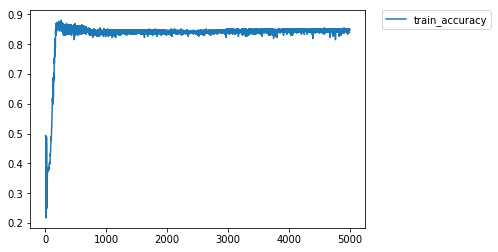

In [19]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

93/93 [==============================] - 0s 392us/step
Test accuracy: 0.7956989157584405


#### Save Model for Use by TF-Serve

In [21]:
# Added code snippet from https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
# to save model for TF-serving

save = False

if save == True:
    MODEL_DIR = "models/"
    version = 1
    export_path = os.path.join(MODEL_DIR, str(version))
    print('export_path = {}\n'.format(export_path))
    if os.path.isdir(export_path):
        print('\nAlready saved a model, cleaning up\n')
        !rm -r {export_path}

    tf.saved_model.simple_save(
        keras.backend.get_session(),
        export_path,
        inputs={'input_data': model.input},
        outputs={t.name:t for t in model.outputs})

    print('\nSaved model:')
    !ls -l {export_path}